# EEG Music Generation

## 1. Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from statistics import median
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct

from tool_wave import *
from tool_midi import *
from tool_generate import *
print("Done")

Done


In [2]:
data=pd.read_csv("./muse-lsl/dataset/test/10sec.csv")
data.describe()

,timestamps,TP9,AF7,AF8,TP10,Right AUX
count,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1.532719e+09,-1.453853,27.388306,47.680665,-45.148309,26.801758
std,2.707200e+00,25.217841,12.116354,71.512755,25.201269,35.254619
min,1.532719e+09,-149.414000,-17.090000,-213.379000,-111.816000,-87.891000
25%,1.532719e+09,-12.695000,20.996000,3.784000,-62.988000,3.418000
50%,1.532719e+09,-1.465000,28.320000,50.049000,-49.316000,27.832000
75%,1.532719e+09,10.742000,34.668000,95.215000,-31.738000,50.293000
max,1.532719e+09,76.660000,65.918000,324.707000,32.227000,125.488000


AF7


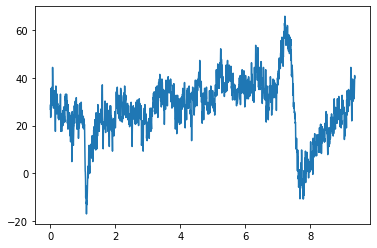

In [3]:
time = data.timestamps-min(data.timestamps)
totaltime = max(time)
samplerate = len(time)/totaltime
track_brain = data.AF7
print(track_brain.name)
plt.plot(time, track_brain)

## 1. FFT and Filter

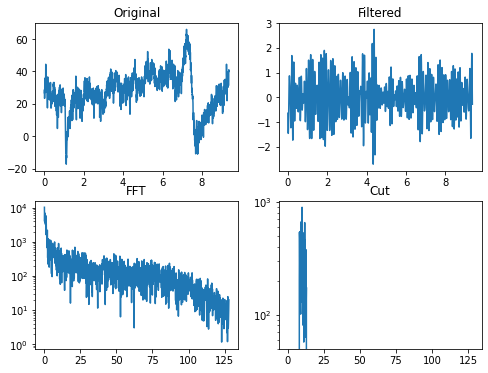

In [4]:
plt.figure(figsize=(8, 6))

# original
plt.subplot(2,2,1)
plt.plot(time, track_brain)
plt.title("Original")

# fft
freqs, complex_arry, pows = brain_fft(time, track_brain)
plt.subplot(2,2,3)
plt.semilogy(freqs[freqs>0], pows[freqs>0])
plt.title("FFT")

# cut
freqs, complex_arry, pows = brain_bandpass(freqs, complex_arry, 8, 13)
plt.subplot(2,2,4)
plt.semilogy(freqs[freqs>0], pows[freqs>0])
plt.title("Cut")

# ifft
alpha = brain_ifft(complex_arry)
plt.subplot(2,2,2)
plt.plot(time, alpha)
plt.title("Filtered")

plt.show()

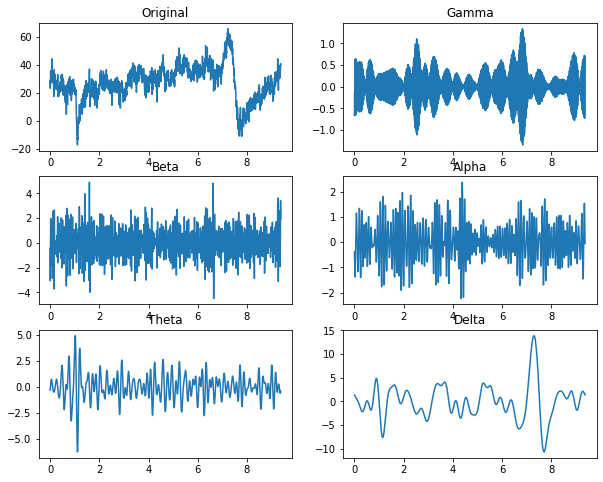

In [5]:
# wave = get_wave(time, track_brain, low, high)
waveGamma = get_wave(time, track_brain,  38, 42)
waveBeta  = get_wave(time, track_brain,  12, 38)
waveAlpha = get_wave(time, track_brain,   8, 12)
waveTheta = get_wave(time, track_brain,   3,  8)
waveDelta = get_wave(time, track_brain, 0.5,  3)

plt.figure(figsize=(10, 8))
plt.subplot(3,2,1)
plt.plot(time, track_brain)
plt.title("Original")
plt.subplot(3,2,2)
plt.plot(time, waveGamma)
plt.title("Gamma")
plt.subplot(3,2,3)
plt.plot(time, waveBeta)
plt.title("Beta")
plt.subplot(3,2,4)
plt.plot(time, waveAlpha)
plt.title("Alpha")
plt.subplot(3,2,5)
plt.plot(time, waveTheta)
plt.title("Theta")
plt.subplot(3,2,6)
plt.plot(time, waveDelta)
plt.title("Delta")
plt.show()

## 3. General Setting

Calculate the most possible beat_per_second, and find the suitable tick per beat and beat per minute.

Input the numerator, denomimator we want, and initialize a mido object.

In [6]:
TPB, BPM = get_TPB_BPM(time, track_brain)

# customize
numerator, denomimator = 4, 4

# create an empty file
mido_obj = mid_parser.MidiFile()

# initialization
mido_obj = general_setting(mido_obj, TPB, BPM, numerator, denomimator)
parseMIDI(mido_obj)

TPB:	 120
BPM:	 128.0409701407448

 > ticks per beat: 120

 > time signatures: 4 / 4

 > tempo: 128.0409701407448

 > number of tracks: 0



## 4. Generation

Cut brain wave into small slices, thus we can calculate 2 variables in each slice: average power and power range.

We have 2 variables to decide in each note: pitch and velocity.

Obviously there are 2 ways to mapping them.

Rule 1: power->pitch, range->velocity

Rule 2: range->pitch, power->velocity

bar	 beat	 step	 minnote	
480 	 120 	 30 	 60 	



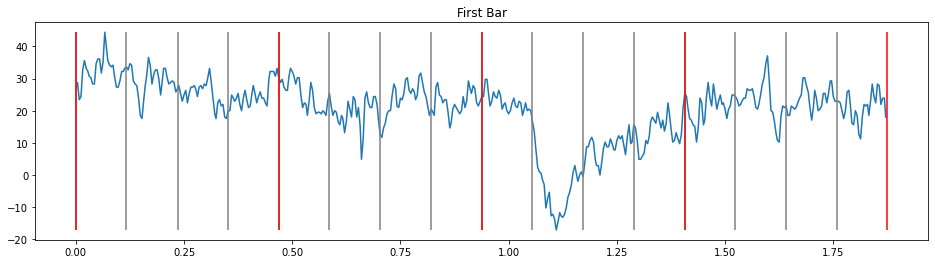

In [7]:
# note length
bar, beat, step, minnote = stock_note_length(mido_obj, magnet=2)

# the first bar
plt.figure(figsize=(16,4))
plt.plot(time[:bar], track_brain[:bar])
plt.vlines(time[0:bar:step], min(track_brain[:bar]), max(track_brain[:bar]), 'grey')
plt.vlines(time[0:bar+1:beat], min(track_brain[:bar]), max(track_brain[:bar]), 'red')
plt.title("First Bar")
plt.show()

When mapping power to pitch, we can input 3 pitches (highest, middle, lowest) to rescale the outcome.

The same goes for mapping range to velocity.

In [21]:
for i in range(0,11,1):
    print('C{}'.format(i), ':\t', i*12)

C0 :	 0
C1 :	 12
C2 :	 24
C3 :	 36
C4 :	 48
C5 :	 60
C6 :	 72
C7 :	 84
C8 :	 96
C9 :	 108
C10 :	 120


Convert:	min	mid	max
power:		 0.50 	 28.34 	 53.15
pitch:		 21 	 60 	 108

Convert:	min	mid	max
range:		 12.21 	 20.26 	 46.88
velocity:	 40 	 80 	 120



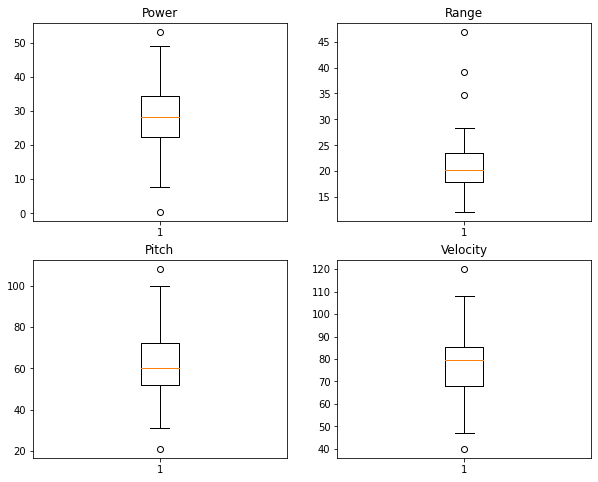

In [8]:
prlist  = powers(time, track_brain, minnote)
funcp2p = func_p2p(prlist, 108, 60, 21)
phlist  = power_pitch(prlist, funcp2p)

rglist  = ranges(time, track_brain, minnote)
funcr2v = func_r2v(rglist, 120, 80, 40)
vtlist  = range_velocity(rglist, funcr2v)

plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.boxplot(prlist)
plt.title("Power")
plt.subplot(2,2,2)
plt.boxplot(rglist)
plt.title("Range")
plt.subplot(2,2,3)
plt.boxplot(phlist)
plt.title("Pitch")
plt.subplot(2,2,4)
plt.boxplot(vtlist)
plt.title("Velocity")
plt.show()

In [9]:
# length of notes
starstime = list(range( 0,       len(time),         minnote))
endstime  = list(range( minnote, len(time)+minnote, minnote))
print(len(starstime), starstime[:4])
print(len(endstime), endstime[:4])
print(len(phlist), phlist[:4])
print(len(vtlist), vtlist[:4])

40 [0, 60, 120, 180]
40 [60, 120, 180, 240]
40 [65, 55, 51, 53]
40 [90, 57, 92, 79]


In [10]:
# create an instrument for mido_obj
track_music = ct.Instrument(program=0, is_drum=False, name=track_brain.name)
mido_obj.instruments.append(track_music)

for i in range(len(starstime)):
    note = ct.Note(start=starstime[i], end=endstime[i], pitch=phlist[i], velocity=vtlist[i])
    mido_obj.instruments[0].notes.append(note)

# parse and check
parseMIDI(mido_obj)

# save as midi
mido_obj.dump('./Rule 1.mid')

 > ticks per beat: 120

 > time signatures: 4 / 4

 > tempo: 128.0409701407448

 > number of tracks: 1
     > number of notes for track AF7 : 40



## 5. Full Example

short ones

In [11]:
data=pd.read_csv("./muse-lsl/dataset/test/10sec.csv")
time = data.timestamps-min(data.timestamps)
track_brain = data.AF7

In [12]:
mido_obj = EEG_MIDI_p2p_r2v(time, track_brain, numerator=4, denomimator=4, magnet=2, pithces=(84,60,36), velocities=(120,80,40))
mido_obj.dump('./files/Rule 1.mid')

Generating MIDI : power->pitch range->velocity ... 

TPB:	 120
BPM:	 128.0409701407448

bar	 beat	 step	 minnote	
480 	 120 	 30 	 60 	

Convert:	min	mid	max
power:		 0.50 	 28.34 	 53.15
pitch:		 36 	 60 	 84

Convert:	min	mid	max
range:		 12.21 	 20.26 	 46.88
velocity:	 40 	 80 	 120

MIDI Generation Complete.



In [13]:
mido_obj = EEG_MIDI_r2p_p2v(time, track_brain, numerator=4, denomimator=4, magnet=2, pithces=(84,60,36), velocities=(120,80,40))
mido_obj.dump('./files/Rule 2.mid')

Generating MIDI : range->pitch power->velocity ... 

TPB:	 120
BPM:	 128.0409701407448

bar	 beat	 step	 minnote	
480 	 120 	 30 	 60 	

Convert:	min	mid	max
range:		 12.21 	 20.26 	 46.88
pitch:		 36 	 60 	 84

Convert:	min	mid	max
power:		 0.50 	 28.34 	 53.15
velocity:	 40 	 80 	 120

MIDI Generation Complete.



long ones

In [14]:
data=pd.read_csv("./muse-lsl/dataset/original_data/name-concentrating-1.csv")
time = data.timestamps-min(data.timestamps)
track_brain = data.AF7

In [15]:
mido_obj = EEG_MIDI_p2p_r2v(time, track_brain, numerator=4, denomimator=4, magnet=2, pithces=(84,60,36), velocities=(120,80,40))
mido_obj.dump('./files/Long Rule 1.mid')

Generating MIDI : power->pitch range->velocity ... 

TPB:	 120
BPM:	 128.01456061399094

bar	 beat	 step	 minnote	
480 	 120 	 30 	 60 	

Convert:	min	mid	max
power:		 3.42 	 31.89 	 56.70
pitch:		 36 	 60 	 84

Convert:	min	mid	max
range:		 9.28 	 23.19 	 126.95
velocity:	 40 	 80 	 120

MIDI Generation Complete.



In [16]:
mido_obj = EEG_MIDI_r2p_p2v(time, track_brain, numerator=4, denomimator=4, magnet=2, pithces=(84,60,36), velocities=(120,80,40))
mido_obj.dump('./files/Long Rule 2.mid')

Generating MIDI : range->pitch power->velocity ... 

TPB:	 120
BPM:	 128.01456061399094

bar	 beat	 step	 minnote	
480 	 120 	 30 	 60 	

Convert:	min	mid	max
range:		 9.28 	 23.19 	 126.95
pitch:		 36 	 60 	 84

Convert:	min	mid	max
power:		 3.42 	 31.89 	 56.70
velocity:	 40 	 80 	 120

MIDI Generation Complete.

